In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
dataTypes = {
    "disbursed_amount": np.float64,
    "asset_cost": np.float64,
    "ltv": np.float64,
    "branch_id": np.object,
    "supplier_id": np.object,
    "manufacturer_id": np.object,
    "Current_pincode_ID": np.object,
    "State_ID": np.object,
    "Employee_code_ID": np.object,
    "Aadhar_flag": np.uint8,
    "PAN_flag": np.uint8,
    "VoterID_flag": np.uint8,
    "Driving_flag": np.uint8,
    "PRI.NO.OF.ACCTS": np.int64,
    "PRI.ACTIVE.ACCTS": np.int64,
    "PRI.OVERDUE.ACCTS": np.int64,
    "PRI.CURRENT.BALANCE ": np.float64,
    "PRI.SANCTIONED.AMOUNT": np.float64,
    "PRI.DISBURSED.AMOUNT": np.float64,
    "PRIMARY.INSTAL.AMT": np.float64,
    "NEW.ACCTS.IN.LAST.SIX.MONTHS": np.int64,
    "DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS": np.int64,
    "AVERAGE.ACCT.AGE": np.int64,
    "CREDIT.HISTORY.LENGTH": np.int64,
    "NO.OF_INQUIRIES": np.int64,
    "Sanctioned": np.float64,
    "AgeAtDisbursal": np.float64,
    "TOTAL.ACTIVE.ACCTS": np.int64,
    "TOTAL.CURRENT.BALANCE": np.float64,
    "TOTAL.DISBURSED.AMOUNT": np.int64,
    "TOTAL.NO.OF.ACCTS": np.int64,
    "TOTAL.OVERDUE.ACCTS": np.int64,
    "TOTAL.CLEAN.ACCTS": np.int64,
    "NO.OF.ACC.BF.SIX.MONTH": np.int64,
    "OVERDUE.ACC.BF.SIX.MONTHS": np.int64,
    "TOTAL.DEACTIVE.ACCTS": np.int64,
    "TOTAL.INSTL.AMOUNT": np.float64,
    "TOTAL.CLEARED.ACCTS": np.int64,
    "Not_Scored": np.uint8,
    "No_History": np.uint8,
    "Very_Low_Risk": np.uint8,
    "Low_Risk": np.uint8,
    "Medium_Risk": np.uint8,
    "Very_High_Risk": np.uint8,
    "Employment.Type_Other": np.uint8,
    "Employment.Type_Salaried": np.uint8,
    "Employment.Type_Self employed": np.uint8,
    "PERFORM_CNS.SCORE_0": np.uint8,
    "PERFORM_CNS.SCORE_3": np.uint8,
    "PERFORM_CNS.SCORE_4": np.uint8,
    "PERFORM_CNS.SCORE_5": np.uint8,
    "PERFORM_CNS.SCORE_6": np.uint8,
    "PERFORM_CNS.SCORE_7": np.uint8,
    "PERFORM_CNS.SCORE_8": np.uint8
}

#Read the input CSV data set
X_train = pd.read_csv("data/X_train.csv", dtype=dataTypes)
X_test = pd.read_csv("data/X_test.csv", dtype=dataTypes)
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

In [3]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 0, stop = 2000, num = 100)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4, 6],
               'bootstrap': [True, False],
               "criterion": ["gini", "entropy"]}
print(random_grid)

{'n_estimators': [0, 20, 40, 60, 80, 101, 121, 141, 161, 181, 202, 222, 242, 262, 282, 303, 323, 343, 363, 383, 404, 424, 444, 464, 484, 505, 525, 545, 565, 585, 606, 626, 646, 666, 686, 707, 727, 747, 767, 787, 808, 828, 848, 868, 888, 909, 929, 949, 969, 989, 1010, 1030, 1050, 1070, 1090, 1111, 1131, 1151, 1171, 1191, 1212, 1232, 1252, 1272, 1292, 1313, 1333, 1353, 1373, 1393, 1414, 1434, 1454, 1474, 1494, 1515, 1535, 1555, 1575, 1595, 1616, 1636, 1656, 1676, 1696, 1717, 1737, 1757, 1777, 1797, 1818, 1838, 1858, 1878, 1898, 1919, 1939, 1959, 1979, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [4]:
## This line instantiates the model. 
rf = RandomForestClassifier() 

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter = 10,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               scoring='roc_auc',
                               n_jobs=-1)

## Fit the model on your training data.
rf_random.fit(X_train, y_train.values.ravel()) 
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1919, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1919, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=gini, bootstrap=True, total= 9.5min
[CV] n_estimators=1919, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.5min remaining:    0.0s


[CV]  n_estimators=1919, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=gini, bootstrap=True, total=10.4min
[CV] n_estimators=1919, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=gini, bootstrap=True 
[CV]  n_estimators=1919, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=gini, bootstrap=True, total=10.4min
[CV] n_estimators=1212, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1212, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini, bootstrap=True, total= 3.3min
[CV] n_estimators=1212, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1212, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini, bootstrap=True, total= 3.2min
[CV] n_estimators=1212, mi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 408.0min finished


{'n_estimators': 1898,
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 40,
 'criterion': 'entropy',
 'bootstrap': True}

In [3]:
model = RandomForestClassifier(n_estimators=1898,
                               min_samples_split=10,
                               min_samples_leaf=6,
                               max_features='auto',
                               max_depth=40,
                               criterion='entropy',
                               bootstrap=True)
model.fit(X_train, y_train.values.ravel()) 
predict_prob = model.predict_proba(X_test)

In [4]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, predict_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC Score: ", roc_auc)

ROC AUC Score:  0.6570101302362472


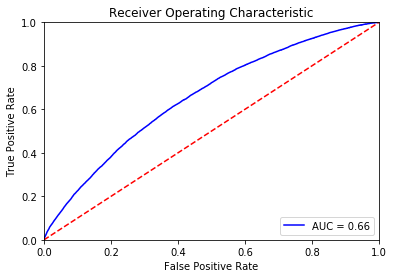

In [5]:
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()